In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from definitions import data_source_path, treatment_countries, fig_size, \
show_plots, save_figs, show_output, target_var, country_col, date_col, incl_countries, incl_years, fake_num
from helper_functions_general import read_data, get_impl_date, get_trans, get_timescale, get_data_path, get_fig_path, get_table_path
from plot_functions import plot_corr

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
timeframe = 'm'

series = read_data(get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}')
series

,country,date,year,month,co2,gdp,ind_prod,infl,infl_energy,unempl,pop,brent,co2_cap,gdp_cap
0,austria,2000-01-01,2000,1,9.726928e+09,5.282880e+10,-0.028,-0.004,-0.004,0.043,8.003000e+06,25.51,1215.410177,6601.124578
1,austria,2000-02-01,2000,2,8.532685e+09,5.285260e+10,0.043,0.008,0.008,0.043,8.004700e+06,27.78,1065.959381,6602.695916
2,austria,2000-03-01,2000,3,8.134567e+09,5.287640e+10,0.006,0.001,0.001,0.041,8.006400e+06,27.49,1016.008070,6604.266587
3,austria,2000-04-01,2000,4,6.546738e+09,5.290020e+10,0.018,-0.002,-0.002,0.038,8.008100e+06,22.76,817.514486,6605.836590
4,austria,2000-05-01,2000,5,5.603262e+09,5.309830e+10,0.020,-0.001,-0.001,0.037,8.010100e+06,27.74,699.524567,6628.918490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,united_kingdom,2019-06-01,2019,6,2.864851e+10,6.229144e+11,-0.005,0.000,0.000,0.038,6.684433e+07,64.22,428.585441,9318.880683
4518,united_kingdom,2019-07-01,2019,7,2.872032e+10,6.188806e+11,-0.002,0.000,0.000,0.038,6.686800e+07,63.92,429.507708,9255.258120
4519,united_kingdom,2019-08-01,2019,8,2.809851e+10,6.292073e+11,-0.008,0.004,0.004,0.038,6.689167e+07,59.04,420.059973,9406.362526
4520,united_kingdom,2019-09-01,2019,9,3.070698e+10,6.395339e+11,0.004,0.001,0.001,0.037,6.691533e+07,62.83,458.892976,9557.360047


(-4.243360277372391, 0.0005559717152271769, 5, 231, {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}, -2437.459709365368)


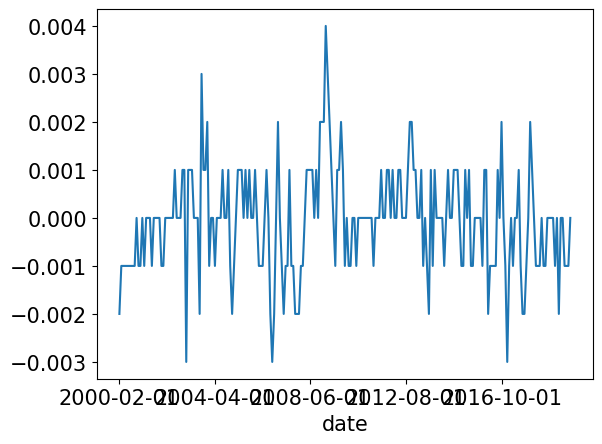

In [6]:
country = 'france'
var_name = 'unempl'
diff_level = 1

series_sub = series[series[country_col]==country]
series_sub = series_sub.set_index(date_col)[var_name]

if diff_level > 0:
    series_sub_diff = series_sub.diff(diff_level).dropna()
else:
    series_sub_diff = series_sub.dropna()

series_sub_diff.plot()

print(adfuller(series_sub_diff))

austria: 	 stationary (0.0)
belgium: 	 stationary (0.0)
bulgaria: 	 stationary (0.001)
croatia: 	 stationary (0.0)
czech_republic: 	 stationary (0.0)
france: 	 stationary (0.0)
germany: 	 stationary (0.0)
greece: 	 stationary (0.005)
hungary: 	 stationary (0.0)
ireland: 	 stationary (0.0)
italy: 	 stationary (0.0)
lithuania: 	 stationary (0.0)
netherlands: 	 stationary (0.0)
portugal: 	 stationary (0.0)
romania: 	 stationary (0.0)
slovakia: 	 stationary (0.0)
spain: 	 stationary (0.0)
switzerland: 	 stationary (0.007)
united_kingdom: 	 stationary (0.0)


100.0% stationary


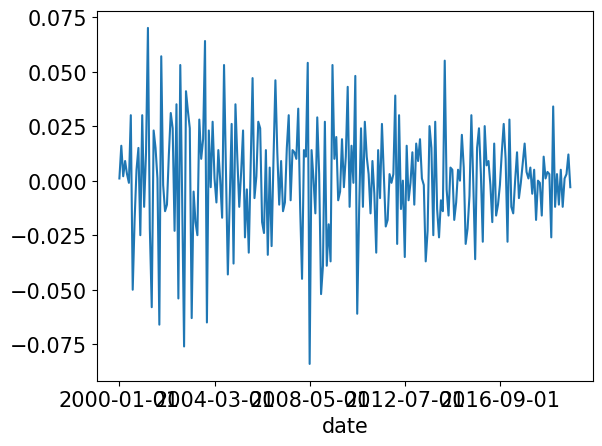

In [13]:
var_name = 'ind_prod'
diff_level = 0
sign_level = 0.1

stat = []
for country in series[country_col].unique():
    series_sub = series[series[country_col]==country].set_index(date_col)[var_name]
#     series_sub = np.log(series[series[country_col]==country].set_index(date_col)[var_name])
    series_sub = series_sub.replace({fake_num: np.nan})
#     series_sub = series_sub - np.mean(series_sub)
    
    if len(series_sub.dropna()) == 0:
        continue
    else:

        if diff_level > 0:
            series_sub_diff = series_sub.diff(diff_level).dropna()
        else:
            series_sub_diff = series_sub.dropna()

        if country=='netherlands':
            series_sub_diff.plot()
            
        adf = adfuller(series_sub_diff, regression='c')
        if adf[1] < sign_level:
            print(f'{country}: \t stationary ({round(adf[1],3)})')
            stat.append(1)
        else:
            print(f'{country}:  \t non-stationary ({round(adf[1],3)})')   
            stat.append(0)

print('\n')
print(f'{round(sum(stat)/len(stat)*100,1)}% stationary')

# Seasonal decomposition

<AxesSubplot:>

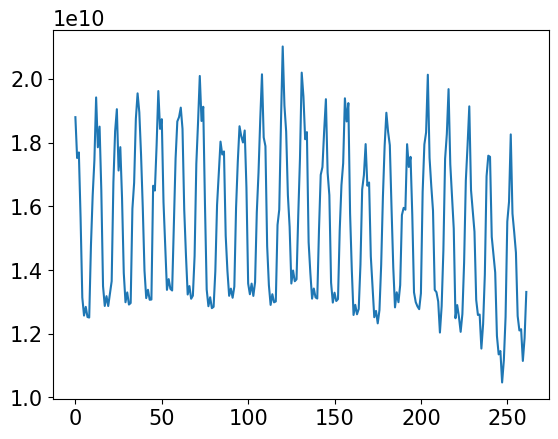

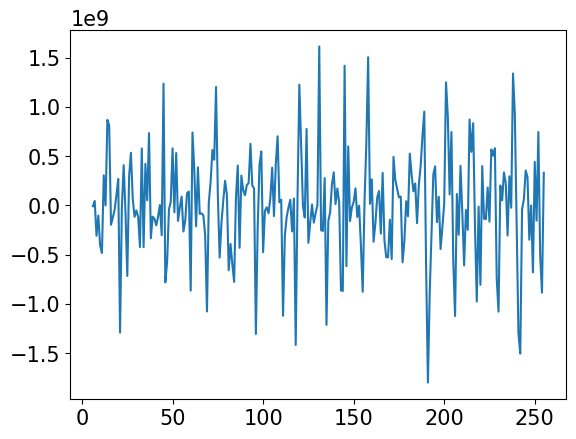

In [171]:
country = 'netherlands'
var_name = 'co2'

series_sub = series[series[country_col]==country]
series_sub = series_sub.reset_index()[var_name]
# series_sub = series_sub.set_index(date_col)[var_name]
# series_sub_log = np.log(series_sub).dropna()
series_sub_log = series_sub

plt.figure(0)
series_sub_log.plot()

decompose_result = seasonal_decompose(series_sub_log, model='additive', period=12)

plt.figure(1)
# series_sub_log_deseason = series_sub_log - decompose_result.trend - decompose_result.seasonal 
series_sub_log_deseason = decompose_result.resid
series_sub_log_deseason.plot()

# Power function

Coefficients: [-0.00030855  0.00777314 -0.05052072  0.02248561  0.21374492]


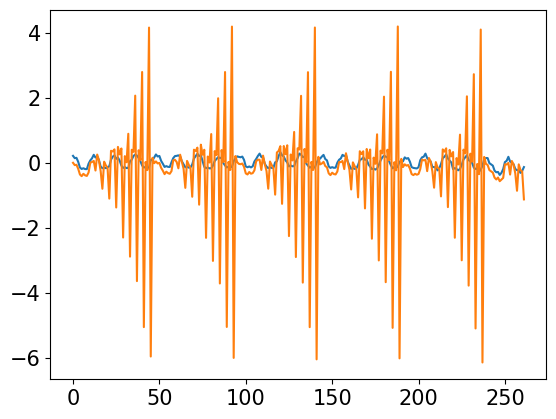

In [87]:
country = 'netherlands'
var_name = 'co2'

series_sub = series[series[country_col]==country]
series_sub = series_sub.reset_index()[var_name]
# series_sub = series_sub.set_index(date_col)[var_name]
series_sub_log = np.log(series_sub)

series_sub_log_mean = series_sub_log - np.mean(series_sub_log)
series_sub_log_mean.plot()

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%12 for i in range(0, len(series_sub_log_mean))]
y = series_sub_log_mean.values

degree = 4
coef = np.polyfit(X, y, degree)
print('Coefficients: %s' % coef)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
        curve.append(value)
        
# create seasonally adjusted
values = series_sub_log_mean.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
    
plt.plot(diff)
plt.show()

In [8]:
dict = {'country': country, 'timeframe': timeframe}